# Калякин Тимофей
# ДЗ 1

## Пункт 1 (2 балла) 

Продумать структуру базы данных и отрисовать в редакторе.

![Screenshot 2025-02-13 at 15.58.42.png](<attachment:Screenshot 2025-02-13 at 15.58.42.png>)
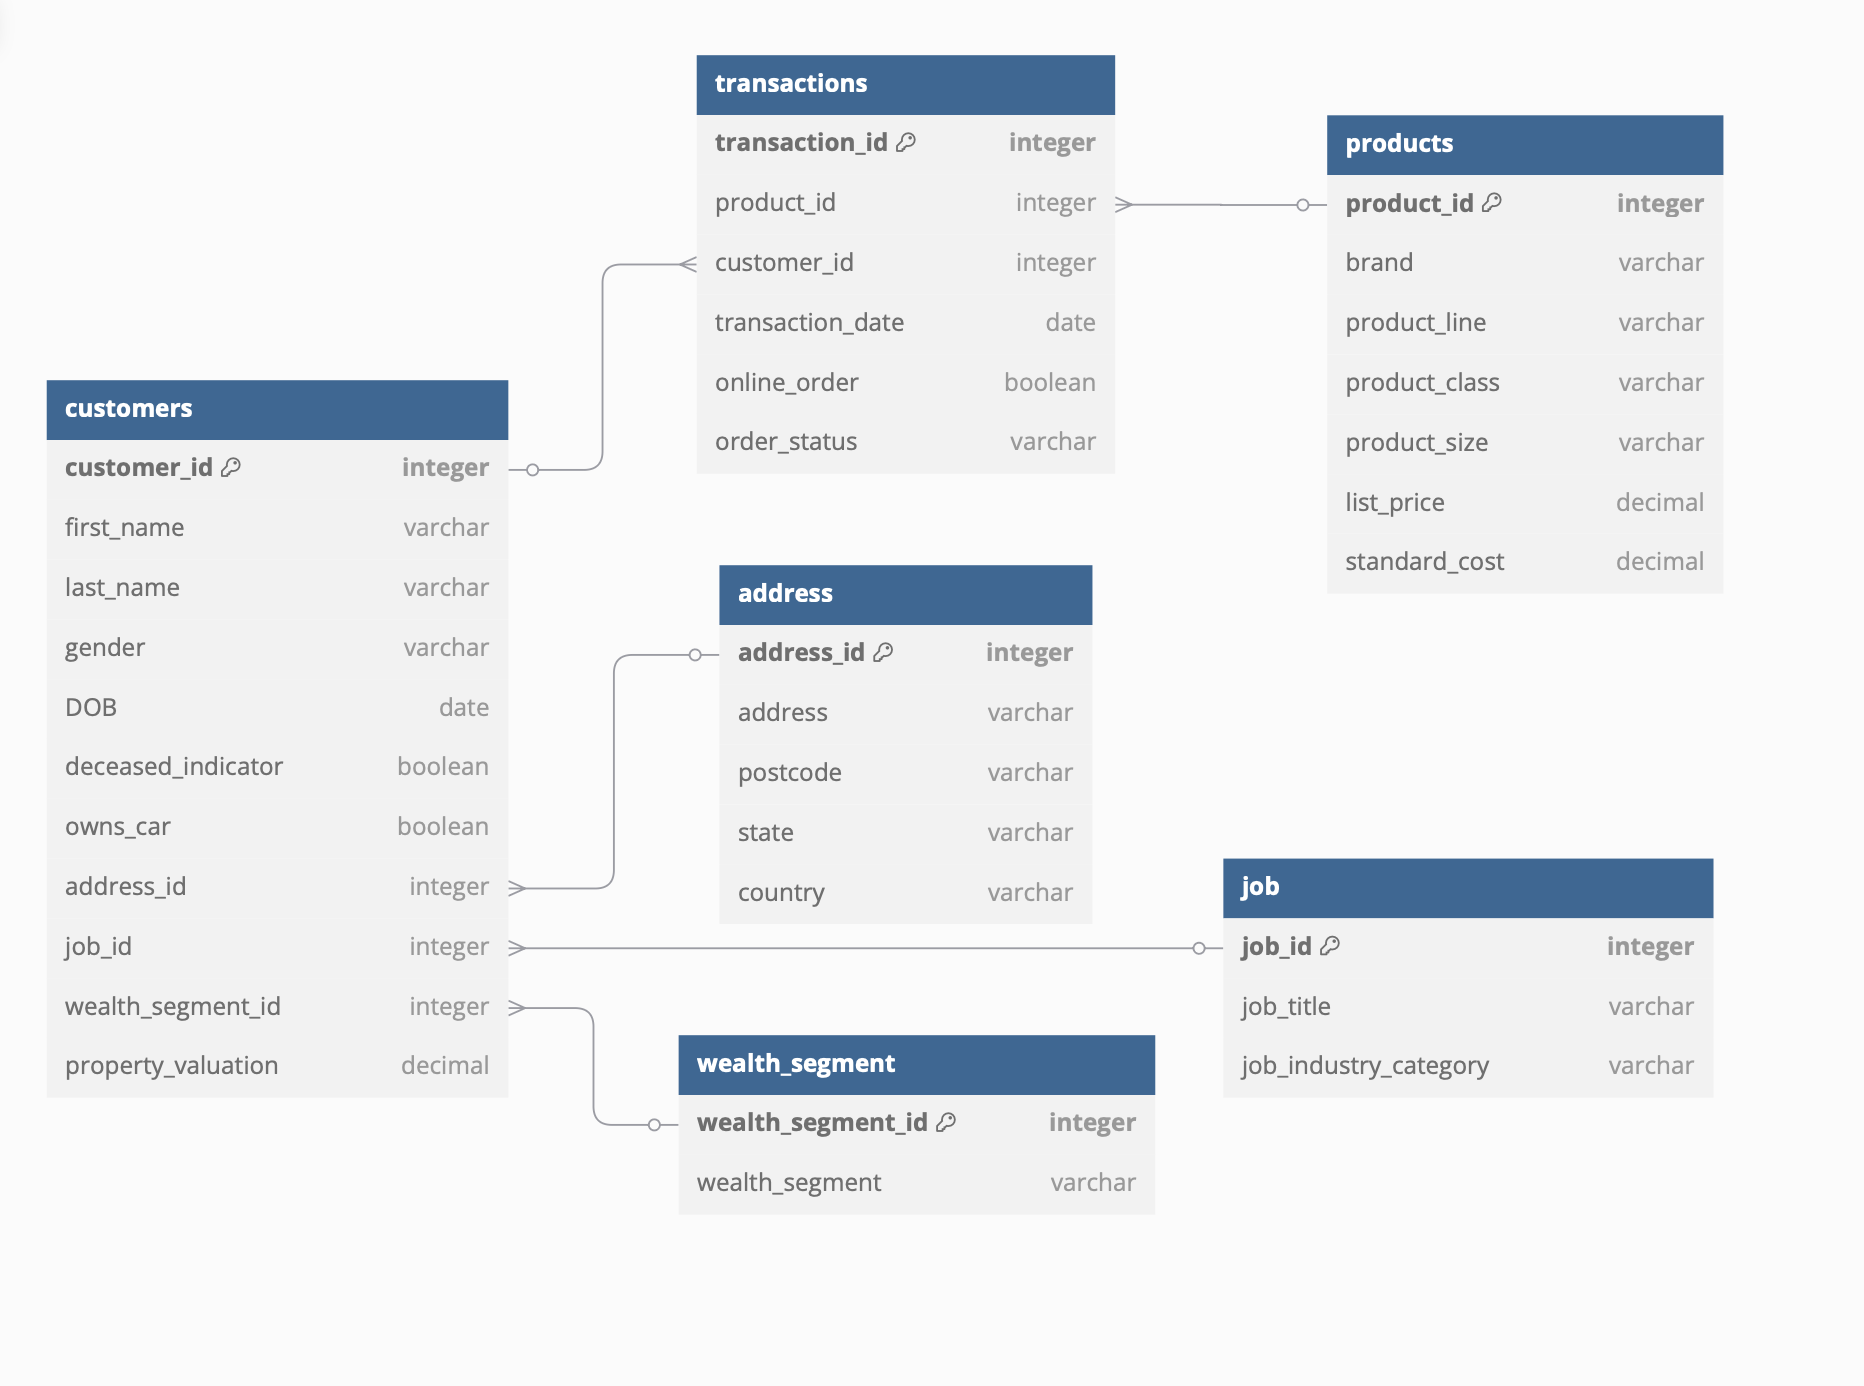

## Пункт 2 (2 балла) 

Нормализовать базу данных (1НФ — 3НФ), описав, к какой нормальной форме приводится таблица и почему таблица в этой нормальной форме изначально не находилась.

Исходная база данных не соответствовала **1НФ**, так как содержала неатомарные данные и потенциальные повторяющиеся группы. Для приведения к **1НФ** были устранены возможные множественные значения в одной ячейке, а каждая таблица получила уникальный первичный ключ.  

На этапе **2НФ** были выявлены частичные зависимости — некоторые атрибуты зависели не от всего первичного ключа, а от его части. Например, `job_title` и `job_industry_category` зависели от `job_id`, а данные о продуктах (`brand`, `product_line`, `product_class`, `product_size`, `list_price`, `standard_cost`) зависели от `product_id`, а не от `transaction_id`. Для устранения этого несоответствия информация была вынесена в отдельные таблицы `job` и `products`, тем самым устраняя частичные зависимости.  

Для приведения к **3НФ** были устранены транзитивные зависимости. В частности, `wealth_segment` зависел от `property_valuation`, а не напрямую от `customer_id`, поэтому была выделена таблица `wealth_segment`. Аналогично, `address` был вынесен в отдельную таблицу, так как атрибуты `postcode`, `state`, `country` зависели от адреса, а не от `customer_id`.  


## Пункт 3 (3 балла) 

Создать все таблицы в DBeaver, указав первичные ключи к таблицам, правильные типы данных, могут ли поля быть пустыми или нет (использовать команду CREATE TABLE).

In [23]:
import psycopg2 as pg
import pandas as pd
import numpy as np

In [3]:
conn = pg.connect(dbname="postgres", host="localhost", user="postgres", password="12345", port=5432)
cursor = conn.cursor()

### Создание таблиц

In [5]:
create_tables_query = '''
CREATE TABLE Address (
    address_id SERIAL PRIMARY KEY,
    address VARCHAR(255),
    postcode VARCHAR(20),
    state VARCHAR(50),
    country VARCHAR(50)
);

CREATE TABLE Job (
    job_id SERIAL PRIMARY KEY,
    job_title VARCHAR(100),
    job_industry_category VARCHAR(100)
);

CREATE TABLE Wealth_Segment (
    wealth_segment_id SERIAL PRIMARY KEY,
    wealth_segment VARCHAR(100)
);

CREATE TABLE Customers (
    customer_id SERIAL PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    gender VARCHAR(10),
    DOB DATE,
    deceased_indicator BOOLEAN,
    owns_car BOOLEAN,
    address_id INT,
    job_id INT,
    wealth_segment_id INT,
    property_valuation DECIMAL(15, 2),
    FOREIGN KEY (address_id) REFERENCES Address(address_id) ON DELETE SET NULL,
    FOREIGN KEY (job_id) REFERENCES Job(job_id) ON DELETE SET NULL,
    FOREIGN KEY (wealth_segment_id) REFERENCES Wealth_Segment(wealth_segment_id) ON DELETE SET NULL
);

CREATE TABLE Products (
    product_id SERIAL PRIMARY KEY,
    brand VARCHAR(50),
    product_line VARCHAR(50),
    product_class VARCHAR(50),
    product_size VARCHAR(20),
    list_price DECIMAL(10, 2),
    standard_cost DECIMAL(10, 2)
);

CREATE TABLE Transactions (
    transaction_id SERIAL PRIMARY KEY,
    product_id INT,
    customer_id INT,
    transaction_date DATE,
    online_order BOOLEAN,
    order_status VARCHAR(50),
    FOREIGN KEY (product_id) REFERENCES Products(product_id) ON DELETE CASCADE,
    FOREIGN KEY (customer_id) REFERENCES Customers(customer_id) ON DELETE CASCADE
);
'''

In [6]:
# Выполняем SQL-запрос для создания таблиц
cursor.execute(create_tables_query)
conn.commit()

In [9]:
# Функция для проверки таблиц
def check_tables(limit=10):
    # Получаем список всех таблиц в схеме public
    cursor.execute("""
        SELECT table_name FROM information_schema.tables 
        WHERE table_schema='public' AND table_type='BASE TABLE'
    """)
    tables = cursor.fetchall()

    print("Список таблиц в базе данных:")
    
    for table in tables:
        table_name = table[0]
        print(f"\n Таблица: {table_name}")

        # Запрашиваем данные из текущей таблицы
        try:
            cursor.execute(f"SELECT * FROM {table_name} LIMIT {limit}")
            rows = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]  
            
            df = pd.DataFrame(rows, columns=colnames)
            print(df)

        except Exception as e:
            print(f"Ошибка при получении данных из {table_name}: {e}")

In [10]:
check_tables()

Список таблиц в базе данных:

 Таблица: address
Empty DataFrame
Columns: [address_id, address, postcode, state, country]
Index: []

 Таблица: customers
Empty DataFrame
Columns: [customer_id, first_name, last_name, gender, dob, deceased_indicator, owns_car, address_id, job_id, wealth_segment_id, property_valuation]
Index: []

 Таблица: job
Empty DataFrame
Columns: [job_id, job_title, job_industry_category]
Index: []

 Таблица: wealth_segment
Empty DataFrame
Columns: [wealth_segment_id, wealth_segment]
Index: []

 Таблица: products
Empty DataFrame
Columns: [product_id, brand, product_line, product_class, product_size, list_price, standard_cost]
Index: []

 Таблица: transactions
Empty DataFrame
Columns: [transaction_id, product_id, customer_id, transaction_date, online_order, order_status]
Index: []


### Загрузка в таблицы

In [24]:
customers_df = pd.read_excel('customer_and_transaction.xlsx', sheet_name='customer')
customers_df = customers_df.replace({np.nan: None})
transactions_df = pd.read_excel('customer_and_transaction.xlsx', sheet_name='transaction')

In [25]:
print(customers_df[:10])

   customer_id      first_name  last_name  gender                  DOB  \
0            1         Laraine  Medendorp       F  1953-10-12 00:00:00   
1            2             Eli    Bockman    Male  1980-12-16 00:00:00   
2            3           Arlin     Dearle    Male  1954-01-20 00:00:00   
3            4          Talbot       None    Male  1961-10-03 00:00:00   
4            5  Sheila-kathryn     Calton  Female  1977-05-13 00:00:00   
5            6            Curr  Duckhouse    Male  1966-09-16 00:00:00   
6            7            Fina     Merali  Female  1976-02-23 00:00:00   
7            8             Rod      Inder    Male  1962-03-30 00:00:00   
8            9            Mala       Lind  Female  1973-03-10 00:00:00   
9           10        Fiorenze    Birdall  Female  1988-10-11 00:00:00   

                              job_title job_industry_category  \
0                   Executive Secretary                Health   
1                Administrative Officer    Financial Se

In [26]:
print(transactions_df[:10])

   transaction_id  product_id  customer_id transaction_date online_order  \
0               1           2         2950       2017-02-25        False   
1               2           3         3120       2017-05-21         True   
2               3          37          402       2017-10-16        False   
3               4          88         3135       2017-08-31        False   
4               5          78          787       2017-10-01         True   
5               6          25         2339       2017-03-08         True   
6               7          22         1542       2017-04-21         True   
7               8          15         2459       2017-07-15        False   
8               9          67         1305       2017-08-10        False   
9              10          12         3262       2017-08-30         True   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved 

In [18]:
# Загружаем уникальные адреса
addresses = customers_df[['address', 'postcode', 'state', 'country']].drop_duplicates()
for _, row in addresses.iterrows():
    cursor.execute("""
        INSERT INTO address (address, postcode, state, country) 
        VALUES (%s, %s, %s, %s) ON CONFLICT DO NOTHING;
    """, (row['address'], row['postcode'], row['state'], row['country']))
conn.commit()

# Загружаем уникальные профессии
jobs = customers_df[['job_title', 'job_industry_category']].drop_duplicates()
for _, row in jobs.iterrows():
    cursor.execute("""
        INSERT INTO job (job_title, job_industry_category) 
        VALUES (%s, %s) ON CONFLICT DO NOTHING;
    """, (row['job_title'], row['job_industry_category']))
conn.commit()

# Загружаем уровни благосостояния
wealth_segments = customers_df[['wealth_segment']].drop_duplicates()
for _, row in wealth_segments.iterrows():
    cursor.execute("""
        INSERT INTO wealth_segment (wealth_segment) 
        VALUES (%s) ON CONFLICT DO NOTHING;
    """, (row['wealth_segment'],))
conn.commit()

# Загружаем уникальные продукты
products = transactions_df[['product_id', 'brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost']].drop_duplicates()
for _, row in products.iterrows():
    cursor.execute("""
        INSERT INTO products (product_id, brand, product_line, product_class, product_size, list_price, standard_cost)
        VALUES (%s, %s, %s, %s, %s, %s, %s) ON CONFLICT DO NOTHING;
    """, (row['product_id'], row['brand'], row['product_line'], row['product_class'], row['product_size'], row['list_price'], row['standard_cost']))
conn.commit()


In [28]:
# Загружаем пользователей, заменяя текстовые значения на ID
for _, row in customers_df.iterrows():
    # Получаем `address_id`
    cursor.execute(
    "SELECT address_id FROM address WHERE address = %s AND postcode = %s",
    (row['address'], str(row['postcode']))  # <-- Преобразуем postcode в строку!
)
    address_id = cursor.fetchone()
    address_id = address_id[0] if address_id else None

    # Получаем `job_id`
    job_title = row['job_title']
    if pd.isna(job_title):
        job_title = None

    # Выполняем SQL-запрос только если `job_title` не None
    if job_title:
        cursor.execute("SELECT job_id FROM job WHERE job_title = %s", (job_title,))
        job_id = cursor.fetchone()
        job_id = job_id[0] if job_id else None
    else:
        job_id = None  

    # Получаем `wealth_segment_id`
    cursor.execute("SELECT wealth_segment_id FROM wealth_segment WHERE wealth_segment = %s", (row['wealth_segment'],))
    wealth_segment_id = cursor.fetchone()[0]

    # Вставляем клиента
    cursor.execute("""
        INSERT INTO customers (customer_id, first_name, last_name, gender, DOB, deceased_indicator, owns_car, address_id, job_id, wealth_segment_id, property_valuation)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """, (row['customer_id'], row['first_name'], row['last_name'], row['gender'], row['DOB'], row['deceased_indicator'], row['owns_car'], address_id, job_id, wealth_segment_id, row['property_valuation']))
conn.commit()


In [ ]:

for _, row in transactions_df.iterrows():
    try:
        # Проверяем существование `customer_id`
        cursor.execute("SELECT customer_id FROM customers WHERE customer_id = %s", (row['customer_id'],))
        customer_check = cursor.fetchone()
        if not customer_check:
            continue  

        # Проверяем существование `product_id`
        cursor.execute("SELECT product_id FROM products WHERE product_id = %s", (row['product_id'],))
        product_check = cursor.fetchone()
        if not product_check:
            continue  

        # Проверяем NaN
        online_order = row['online_order']
        if pd.isna(online_order):  
            online_order = None
        else:
            online_order = bool(online_order) 

        order_status = row['order_status']
        if pd.isna(order_status):  
            order_status = None

        # Вставляем транзакцию
        cursor.execute("""
            INSERT INTO transactions (transaction_id, product_id, customer_id, transaction_date, online_order, order_status)
            VALUES (%s, %s, %s, %s, %s, %s);
        """, (row['transaction_id'], row['product_id'], row['customer_id'], row['transaction_date'], online_order, order_status))

    except Exception as e:
        print(f"Ошибка при обработке строки {row['transaction_id']}: {e}")

conn.commit()



In [32]:
check_tables()

Список таблиц в базе данных:

 Таблица: address
   address_id                  address postcode            state    country
0           1       060 Morning Avenue     2016  New South Wales  Australia
1           2      6 Meadow Vale Court     2153  New South Wales  Australia
2           3       0 Holy Cross Court     4211              QLD  Australia
3           4      17979 Del Mar Point     2448  New South Wales  Australia
4           5         9 Oakridge Court     3216              VIC  Australia
5           6         4 Delaware Trail     2210  New South Wales  Australia
6           7      49 Londonderry Lane     2650  New South Wales  Australia
7           8          97736 7th Trail     2023  New South Wales  Australia
8           9     93405 Ludington Park     3044              VIC  Australia
9          10  44339 Golden Leaf Alley     4557              QLD  Australia

 Таблица: customers
   customer_id      first_name  last_name  gender         dob  \
0            1         Laraine

In [33]:
# Закрываем соединение
cursor.close()
conn.close()